<a href="https://colab.research.google.com/github/UKJaagadhep/Data-science-and-machine-learning/blob/main/Face%20Generation%20with%20DCGAN/Face_Generation_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Reshape, LeakyReLU, Dropout, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Layer)

# **DOWNLOADING DATA FROM KAGGLE**

In [2]:
!pip install -q kaggle
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip "/content/celeba-dataset.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: /content/dat

# **CONFIGURATION**

In [3]:
batch_size = 128
im_shape = (64,64,3)
learning_rate = 2e-4
latent_dimension = 100
epochs = 20

# **TENSORFLOW DATASET**

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/dataset/img_align_celeba/img_align_celeba", label_mode = None, image_size = (im_shape[0], im_shape[1]), batch_size = batch_size)

Found 202599 files belonging to 1 classes.


In [5]:
dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

# **PREPROCESSING**

In [6]:
#TO GET VALUES BETWEEN -1 AND +1
def scale_preprocess(image):
  return tf.cast(image, tf.float32) / 127.5 - 1.0

In [7]:
train_dataset = (
    dataset
    .map(scale_preprocess)
    .unbatch()
    .shuffle(reshuffle_each_iteration = True, buffer_size = 1024)
    .batch(batch_size = batch_size, drop_remainder = True)
    .prefetch(tf.data.AUTOTUNE)
)

In [8]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(128, 64, 64, 3), dtype=tf.float32, name=None)>

# **VISUALIZATION**

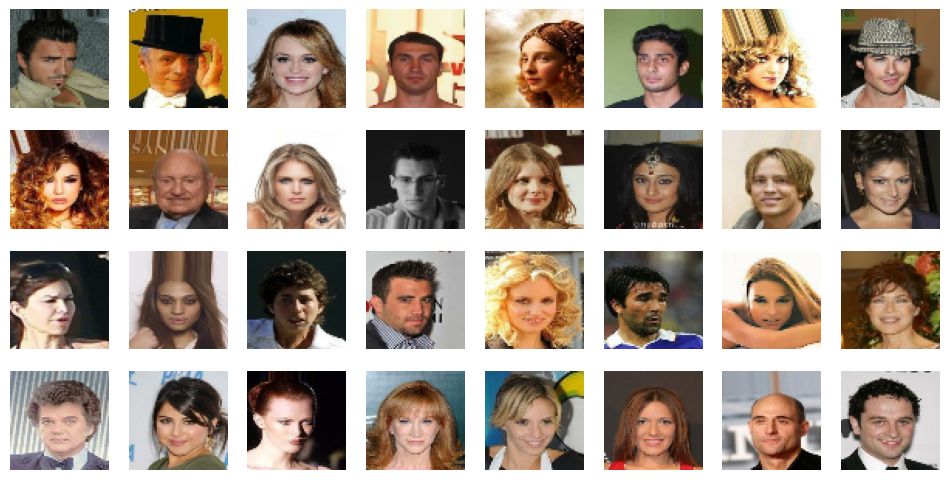

In [24]:
for d in train_dataset.take(1):
  k = 0
  plt.figure(figsize = (12, 6))
  for i in range(32):
    ax = plt.subplot(4, 8, k+1)
    plt.imshow((d[i]+1)/2) #WE DO (d[i]+1)/2 TO CONVERT VALUES IN [-1,1] TO VALUES IN [0,1]
    plt.axis('off')
    k += 1

# **MODELING**

## **GENERATOR**

In [25]:
generator = tf.keras.Sequential([
    Input(shape = (latent_dimension)),
    Dense(4 * 4 * latent_dimension),
    Reshape((4, 4, latent_dimension)),

    Conv2DTranspose(512, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(256, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(3, kernel_size = 4, strides = 2, padding = 'same', activation = tf.keras.activations.tanh)
], name = 'generator')
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1600)              161600    
                                                                 
 reshape (Reshape)           (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 512)         819712    
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 8, 8, 512)         2048      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 256)       20

## **DISCRIMINATOR**

In [26]:
discriminator = tf.keras.Sequential([
    Input(shape = (im_shape[0], im_shape[1], 3)),

    Conv2D(64, kernel_size = 4, strides = 2, padding = 'same'),
    LeakyReLU(0.2),

    Conv2D(128, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(256, kernel_size = 4, strides = 2, padding = 'same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(1, kernel_size = 4, strides = 2, padding = 'same'),

    Flatten(),

    Dense(1, activation = 'sigmoid')
], name = 'discriminator')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_3 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544    
                                                     

## **GAN**

In [27]:
#TO VISUALIZE GENERATOR GENERATED IMAGES AT THE END OF EACH EPOCH
class ShowImage(tf.keras.callbacks.Callback):
  def __init__(self, latent_dimension = 100):
    self.latent_dimension = latent_dimension

  def on_epoch_end(self, epoch, logs = None):
    n= 6
    k = 0
    out = self.model.generator(tf.random.normal(shape = (36, self.latent_dimension)))
    plt.figure(figsize = (16, 16))
    for i in range(n):
      for j in range(n):
        ax = plt.subplot(n, n, k+1)
        plt.imshow((out[k]+1)/2)
        plt.axis('off')
        k += 1
    plt.savefig("generated/gen_images_epoch_{}.png".format(epoch+1))

In [28]:
!mkdir generated

In [29]:
class GAN(tf.keras.Model):
  def __init__(self, discriminator, generator):
    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    self.g_optimizer = g_optimizer
    self.d_optimizer = d_optimizer
    self.loss_fn = loss_fn
    self.d_loss_metric = tf.keras.metrics.Mean(name = 'd_loss')
    self.g_loss_metric = tf.keras.metrics.Mean(name = 'g_loss')

  @property
  def metrics(self):
    return [self.d_loss_metric, self.g_loss_metric]

  def train_step(self, real_images):
    batch_size = tf.shape(real_images)[0]

    ###DISCRIMINATOR
    #GENERATING FAKE IMAGES
    random_noise = tf.random.normal(shape = (batch_size, latent_dimension))
    fake_images = self.generator(random_noise)

    #+ 0.25 * tf.random.uniform((batch_size, 1), min_val = -1, max_val = 1)  IS ADDED FOR SMOOTHENING LABELS
    real_labels = tf.ones((batch_size, 1)) + 0.25 * tf.random.uniform((batch_size, 1), minval = -1, maxval = 1)
    fake_labels = tf.zeros((batch_size, 1)) + 0.25 * tf.random.uniform((batch_size, 1), minval = 0, maxval = 1)

    with tf.GradientTape() as recorder:
      real_predictions = self.discriminator(real_images)
      d_loss_real = self.loss_fn(real_labels, real_predictions)

      fake_predictions = self.discriminator(fake_images)
      d_loss_fake = self.loss_fn(fake_labels, fake_predictions)

      d_loss = d_loss_real + d_loss_fake

    partial_derivatives = recorder.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator.trainable_weights))

    ###GENERATOR
    random_noise= tf.random.normal(shape = (batch_size, latent_dimension))
    flipped_fake_labels = tf.ones((batch_size, 1))

    with tf.GradientTape() as recorder:
      fake_predictions = self.discriminator(self.generator(random_noise)) #FAKE IMAGES SHOULD BE GENERATED INSIDE THE GRADIENT TAPE METHOD
      g_loss = self.loss_fn(flipped_fake_labels, fake_predictions)

    partial_derivatives = recorder.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(partial_derivatives, self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)

    return {'d_loss':self.d_loss_metric.result(),
            'g_loss':self.g_loss_metric.result()}

# **MODEL COMPILATION AND TRAINING**

In [30]:
gan = GAN(discriminator, generator)
gan.compile(
    d_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1= 0.5),
    g_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.5),
    loss_fn = tf.keras.losses.BinaryCrossentropy(),
)

In [31]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(128, 64, 64, 3), dtype=tf.float32, name=None)>

In [ ]:
history = gan.fit(train_dataset, epochs = epochs, callbacks = [ShowImage(latent_dimension)])

Epoch 1/20
      6/Unknown - 2s 187ms/step - d_loss: 1.1639 - g_loss: 0.9007

1582/1582 [==============================] - 342s 215ms/step - d_loss: 1.1823 - g_loss: 0.9251
Epoch 2/20
1582/1582 [==============================] - 302s 191ms/step - d_loss: 1.2144 - g_loss: 0.8656
Epoch 3/20
1582/1582 [==============================] - 303s 191ms/step - d_loss: 1.2243 - g_loss: 0.8554
Epoch 4/20
1582/1582 [==============================] - 304s 192ms/step - d_loss: 1.2224 - g_loss: 0.8505
Epoch 5/20
1582/1582 [==============================] - 303s 191ms/step - d_loss: 1.2273 - g_loss: 0.8403
Epoch 6/20
1582/1582 [==============================] - 304s 192ms/step - d_loss: 1.2242 - g_loss: 0.8327
Epoch 7/20
1582/1582 [==============================] - 303s 191ms/step - d_loss: 1.2180 - g_loss: 0.8437
Epoch 8/20
1582/1582 [==============================] - 303s 191ms/step - d_loss: 1.2223 - g_loss: 0.8315
Epoch 9/20
1582/1582 [==============================] - 304s 192ms/step - d_loss: 1.2183 - g_loss: 0.8435
Epoch 10/20
1582/1582 [==============================] - 

# **DISPLAYING OUTPUT (GENERATED IMAGE AND LOSS-EPOCH GRAPH)**

In [ ]:
from IPython.display import Image, display

image_path = "path/to/your/image.jpg"

display(Image(filename=image_path))


In [ ]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['d_loss', 'g_loss'], loc='upper left')
plt.show()